# ДЗ №2. PyTorch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from math import sin, exp

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Define utililty classes and functions

In [2]:
# define the function which we are going to approximate

def f(x, y):
    t = (2*x + y)
    return sin(x + 2*y) * exp(-t*t)

In [3]:
# define a dataset class - it is just a wrapper for the data

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.__X = X
        self.__y = y

    def __len__(self):
        return len(self.__X)

    def __getitem__(self, idx):
        return self.__X[idx], self.__y[idx]

In [4]:
# Define the neural network architecture. The number of layers and neurons was selected empirically.

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.__layer_sequence = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.__layer_sequence(x)

In [5]:
# define functions to train and test the model

def train_one_epoch(loss_fn, dataloader):
    loss_sum = 0
    
    model.train() # enable the training mode
    for _, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward() # calculate the gradients
        optimizer.step() # update weights of the model
        optimizer.zero_grad()

        loss_sum += loss.item()

    n_batches = len(dataloader)
    avg_loss = loss_sum / n_batches
    return avg_loss


def test_one_epoch(loss_fn, dataloader):
    loss_sum = 0
    
    model.eval() # enable the evaluation mode
    with torch.no_grad():
        for _, (X, y) in enumerate(dataloader):
            X = X.to(device) # move the data to the device

            pred = model(X)
            loss_sum += loss_fn(pred, y).item()
    
    n_batches = len(dataloader)
    avg_loss = loss_sum / n_batches
    return avg_loss


def train_model(n_epochs, loss_fn, train_dataloader, validation_dataloader):
    print('Training...')

    train_loss_list = []
    validation_loss_list = []

    for i in tqdm(range(n_epochs)):
        train_loss = train_one_epoch(loss_fn, train_dataloader)
        train_loss_list.append(train_loss)
        
        validation_loss = test_one_epoch(loss_fn, validation_dataloader)
        validation_loss_list.append(validation_loss)

    print('Done!')
    return train_loss_list, validation_loss_list

## Train and test the model

Сгенерируем данные.

In [6]:
n_samples = 20_000
# random values in the interval [-10, 10)
X = torch.rand((n_samples, 2)) * 20 - 10
# apply the original function f(a,b)
y = torch.tensor([f(sample[0], sample[1]) for sample in X]).unsqueeze(1)

# split data into train, validation and test datasets
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.7, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

# wrap data into MyDataset and DataLoader
train_dataset = MyDataset(X_train, y_train)
validation_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)

batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Обучим и протестируем модель.

In [7]:
# create an instance of the model
model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# run train and test loops
torch.manual_seed(123)
n_epochs = 150
train_loss_list, validation_loss_list = train_model(n_epochs, loss_fn, train_dataloader, validation_dataloader)
test_loss = test_one_epoch(loss_fn, test_dataloader)

print(f'Last train loss: {train_loss_list[-1]}')
print(f'Last validation loss: {validation_loss_list[-1]}')
print(f'Best validation loss: {np.min(validation_loss_list)}, Epoch: {np.argmin(validation_loss_list) + 1}')
print(f'Train loss: {test_loss}')

Training...


100%|██████████| 150/150 [02:14<00:00,  1.12it/s]

Done!
Last train loss: 0.00020604954109082675
Last validation loss: 0.00018227945229227772
Best validation loss: 0.000138746665288636, Epoch: 140
Train loss: 0.00020559176073220442


Посмотрим как менялось значение функции потерь во время обучения. Этот график использовался для подбора параметров модели, а также оптимального числа эпох.

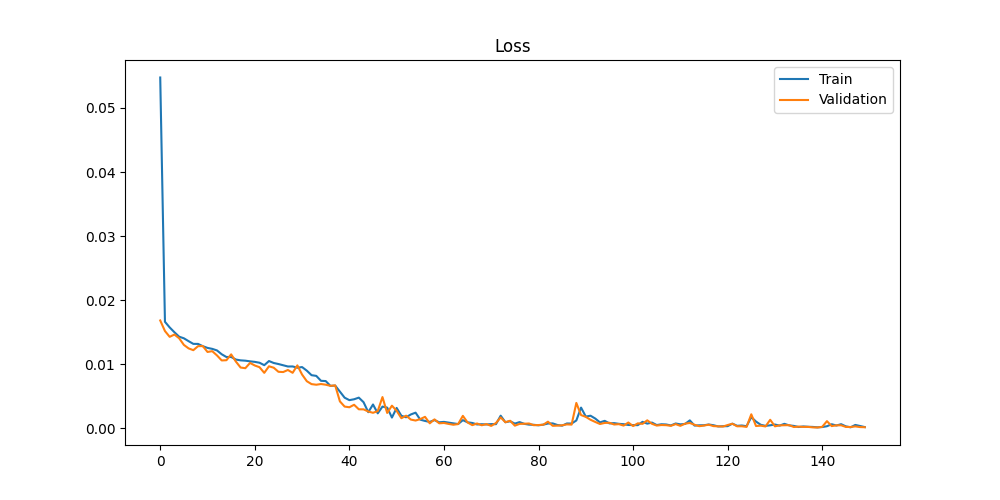

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

X = range(n_epochs)
ax.plot(X, train_loss_list, label='Train')
ax.plot(X, validation_loss_list, label='Validation')

ax.set_title('Loss')
ax.legend()
plt.show()

Построим графики истинной функции и аппроксимированного варианта.


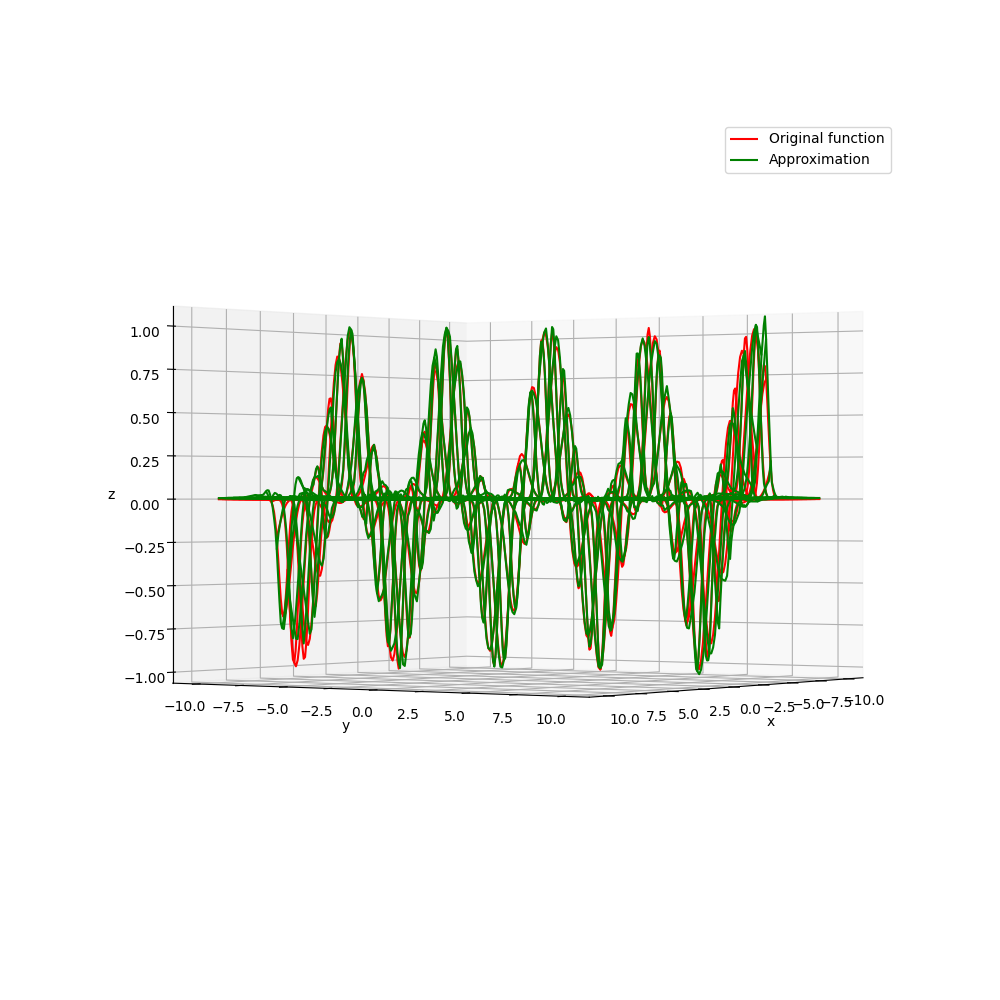

In [9]:
def model_fn(x, y):
    input = torch.tensor((x, y)).to(torch.float32)
    model.eval()
    with torch.no_grad():
        return model(input)

X = Y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(X, Y)

fvec = np.vectorize(f)
Z1 = fvec(X, Y)

model_fnvec = np.vectorize(model_fn)
Z2 = model_fnvec(X, Y)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 35, 0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot_wireframe(X, Y, Z1, color='red', label='Original function')
ax.plot_wireframe(X, Y, Z2, color='green', label='Approximation')
ax.legend()

plt.show()